In [60]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [18]:
# Détection du GPU

device = (
    "cuda"
    if torch.cuda.is_available()
    else
    "cpu"
)

print(device)

print(torch.cuda.get_device_name(0))

cuda
NVIDIA GeForce RTX 4070 Laptop GPU


In [19]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader.DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader.DataLoader(test_data, batch_size=64)

# classes
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]

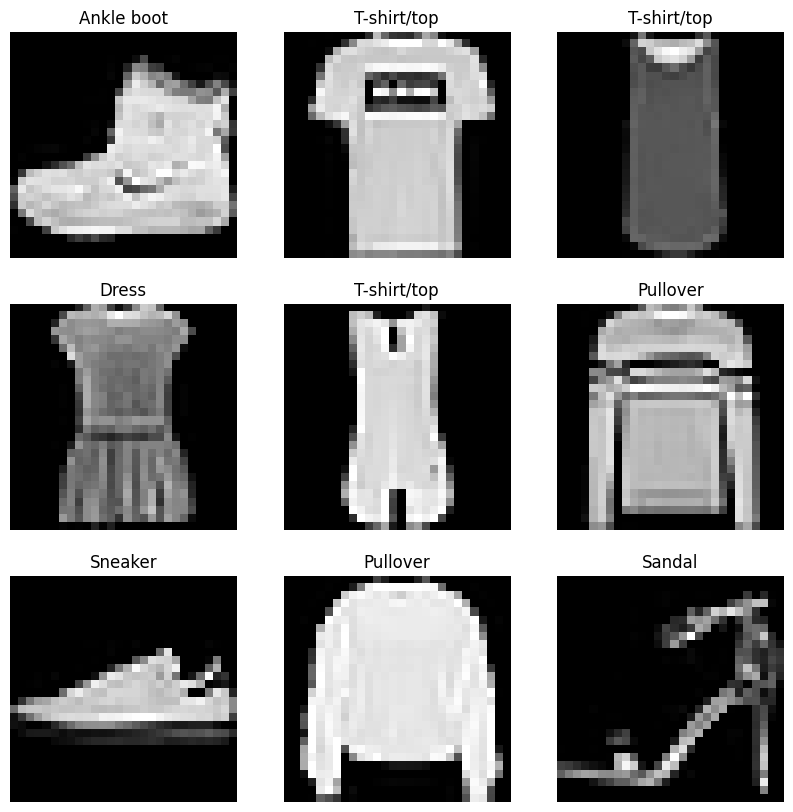

In [20]:
# Plot some images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(training_data[i][0].squeeze(), cmap="gray")
    index = training_data[i][1]
    plt.title(classes[index])
    plt.axis("off")

In [33]:
""" # Create the model # Pour commenter un bloc de code, on peut utiliser les triples guillemets avec alt+shift+a
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512), # 512 neurones sur la couche donc 512 sorties
            nn.ReLU(), # 0 si =<0 et linéaire > 0
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)

print(model) """

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [52]:
# Create the model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(11*11*128, 10) # après flatten la taille est de 128*11*11 car 128 filtres et 11*11
        self.CNN_stack = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1), # paramètres : 1 cannal d'entrée car images en niveaux de gris, 32 filtres, kernel de 3x3, stride = 1 et padding = 0
            nn.BatchNorm2d(32), # Sortie de la convolution = [1, 32, 26, 26] car (28-3+2*0)/1 + 1 = 26
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1), # Sortie de la convolution = [1, 64, 24, 24] car (26-3+2*0)/1 + 1 = 24
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1), # Sortie de la convolution = [1, 128, 22, 22] car (24-3+2*0)/1 + 1 = 22
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # La sortie de maxpooling est [1, 128, 11, 11] car (22-2)/2 + 1 = 11
            # Flatten pour passer de 3D à 1D pour la fully connected layer
            # Fullt connected layer
            # Softmax pour la classification
        )

    def forward(self, x):
        x = self.CNN_stack(x)
        x = self.flatten(x)
        print(x.shape)
        x = self.linear(x)
        x = F.softmax(x, dim=1)
        return x

model = NeuralNetwork().to(device)

print(model)

# Création d'une variable pour tester le modèle
dummy_input = torch.randn(1, 1, 28, 28).to(device)  # Variable pour tester le modèle

with torch.no_grad(): # Pas de calcul de gradient, calcul uniquement pour l'entraînement
    output = model.CNN_stack(dummy_input) # On passe l'image dans le CNN_stack donc après les 3 conv et le maxpooling
    print("Output shape after convolutions and maxpooling:", output.shape) # On trouve comme calculé à la main 128 filtres de 11x11
    output2 = model(dummy_input) # On passe l'image dans le modèle complet
    print("Output shape after the whole model:", output2.shape)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=15488, out_features=10, bias=True)
  (CNN_stack): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)
Output shape after convolutions and maxpooling: torch.Size([1, 128, 11, 11])
torch.Size([1, 15488])
Output shape after the whole model: torch.Size([1, 10])


In [53]:
# Optimization loop
learning_rate = 1e-3
batch_size = 64
epochs = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
utilization_gpu = []
for param in model.parameters():
    print(type(param), param.size()) # Affiche les paramètres du modèle cad les poids et les biais

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        utilization_gpu.append(torch.cuda.memory_allocated(device=device))

        # Backpropagation
        optimizer.zero_grad() # Remet à zéro les gradients
        loss.backward() # Calcule les gradients
        optimizer.step() # Met à jour les paramètres

        if batch % 100 == 0: # si le batch est un multiple de 100
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

<class 'torch.nn.parameter.Parameter'> torch.Size([10, 15488])
<class 'torch.nn.parameter.Parameter'> torch.Size([10])
<class 'torch.nn.parameter.Parameter'> torch.Size([32, 1, 3, 3])
<class 'torch.nn.parameter.Parameter'> torch.Size([32])
<class 'torch.nn.parameter.Parameter'> torch.Size([32])
<class 'torch.nn.parameter.Parameter'> torch.Size([32])
<class 'torch.nn.parameter.Parameter'> torch.Size([64, 32, 3, 3])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([128, 64, 3, 3])
<class 'torch.nn.parameter.Parameter'> torch.Size([128])
<class 'torch.nn.parameter.Parameter'> torch.Size([128])
<class 'torch.nn.parameter.Parameter'> torch.Size([128])


In [54]:
def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval().to(device)
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Epoch 1
-------------------------------
torch.Size([64, 15488])
loss: 1.623014 [    0/60000]
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 154

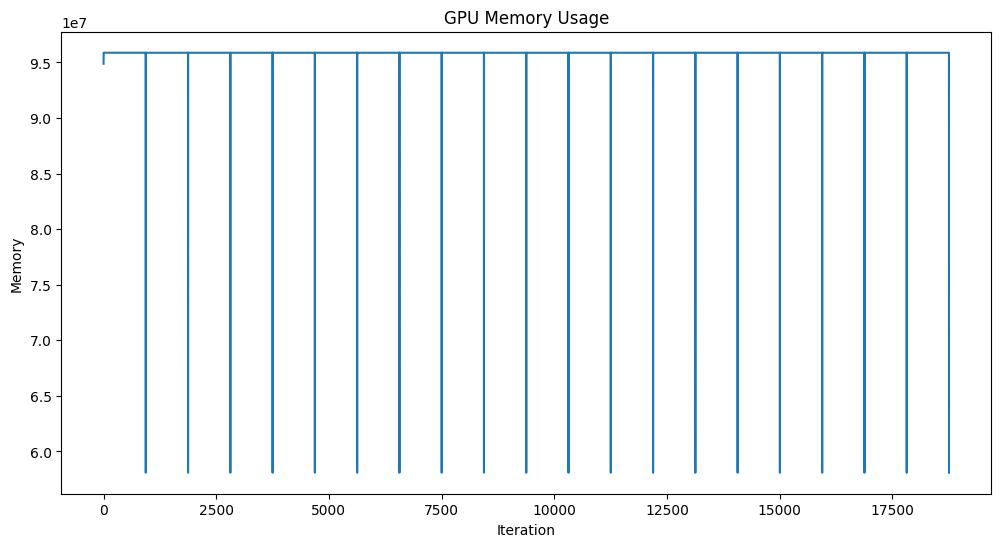

In [57]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

plt.figure(figsize=(12, 6))
plt.plot(utilization_gpu)
plt.xlabel('Iteration')
plt.ylabel('Memory')
plt.title('GPU Memory Usage')
plt.show()

torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 15488])
torch.Size([64, 

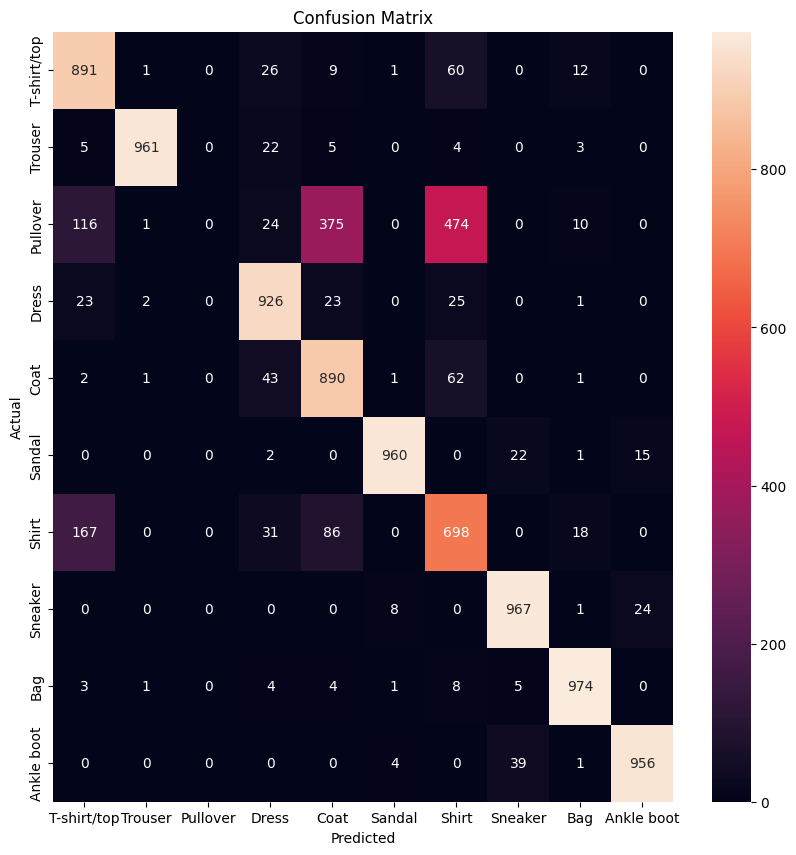

In [ ]:
# Confusion matrix

model.eval()
y_pred = []
y_true = []
idx_failed_pred = []
correct = 0
total = 0
with torch.no_grad():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        y_pred.extend(pred.argmax(1).tolist())
        y_true.extend(y.tolist())
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        total += y.size(0)
        if (y_pred == y_true):
            idx_failed_pred.append(0)  # ICI CORRIGER LE CODE
        else:
            idx_failed_pred.append(1)

cm = confusion_matrix(y_true, y_pred)
print(cm)
print(f"Accuracy: {correct*100/total} %")


plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

157
10000
10000


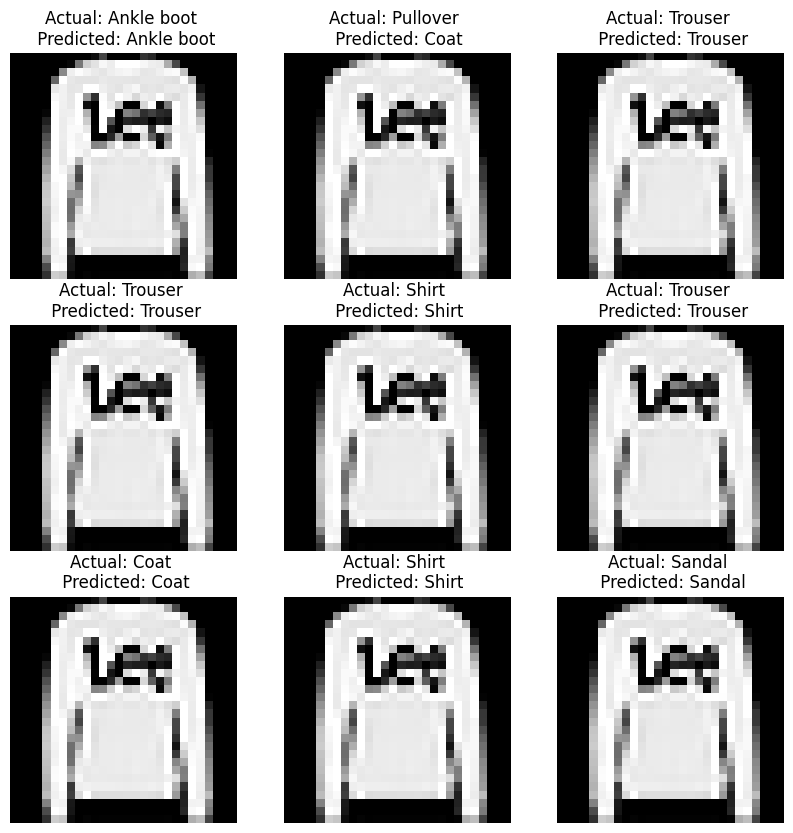

In [86]:
# Afficher les images mal prédites
print(len(idx_failed_pred))
print(total)
print(len(y_pred))
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_data[idx_failed_pred[i]][0].squeeze(), cmap="gray")
    index = test_data[idx_failed_pred[i]][1]
    plt.title(f"Actual: {classes[y_true[i]]} \n Predicted: {classes[y_pred[i]]}")
    plt.axis("off")